In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
from utils import *
from rnn import *

In [2]:
def findFiles(path):
    return glob.glob(path)

In [3]:
print(findFiles('data/data/names/*.txt'))

['data/data/names/Czech.txt', 'data/data/names/German.txt', 'data/data/names/Arabic.txt', 'data/data/names/Japanese.txt', 'data/data/names/Chinese.txt', 'data/data/names/Vietnamese.txt', 'data/data/names/Russian.txt', 'data/data/names/French.txt', 'data/data/names/Irish.txt', 'data/data/names/English.txt', 'data/data/names/Spanish.txt', 'data/data/names/Greek.txt', 'data/data/names/Italian.txt', 'data/data/names/Portuguese.txt', 'data/data/names/Scottish.txt', 'data/data/names/Dutch.txt', 'data/data/names/Korean.txt', 'data/data/names/Polish.txt']


In [4]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
category_lines = {}
all_categories = []

In [6]:
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines] 

In [7]:
for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [8]:
n_categories = len(all_categories)

In [9]:
# category_lines['Chinese']

In [10]:
import torch

In [11]:
def letterToIndex(letter):
    return ALL_LETTERS.find(letter)

In [12]:
def letterToTensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [13]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
# print(letterToTensor('J'))

In [15]:
# print(lineToTensor('Jones'))

In [16]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [17]:
input = letterToTensor('A')
print(input.size())
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

torch.Size([1, 57])


In [18]:
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [19]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)

In [20]:
print(output)

tensor([[-2.8405, -2.9463, -2.9774, -2.9065, -2.8635, -2.9387, -2.9182, -2.8908,
         -2.9721, -2.7553, -2.8425, -2.8744, -2.8456, -2.8385, -2.9365, -2.9672,
         -2.8751, -2.8671]], grad_fn=<LogSoftmaxBackward0>)


In [21]:
print(categoryFromOutput(output, all_categories))

('English', 9)


In [22]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Jimbo
category = Italian / line = Verona
category = German / line = Carver
category = English / line = Emsden
category = Portuguese / line = Freitas
category = English / line = Frost
category = French / line = Vipond
category = Russian / line = Zhedrinsky
category = Vietnamese / line = Ly
category = Czech / line = Ransom


In [23]:
learning_rate = 0.001
criterion = nn.NLLLoss()

In [24]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
        
    return output, loss.item()

In [25]:
import time
import math

In [26]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output, all_categories)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.8955 Yakutin / English ✗ (Russian)
10000 10% (0m 6s) 2.8236 Trang / Chinese ✗ (Vietnamese)
15000 15% (0m 10s) 2.3458 Varvitsiotes / Greek ✓
20000 20% (0m 13s) 2.6527 Deforest / Greek ✗ (French)
25000 25% (0m 16s) 2.6780 Danas / Arabic ✗ (Greek)
30000 30% (0m 20s) 2.3572 Victor / English ✓
35000 35% (0m 23s) 1.7383 Vuu / Chinese ✗ (Vietnamese)
40000 40% (0m 27s) 2.6660 Schnoor / Scottish ✗ (German)
45000 45% (0m 30s) 3.7682 Shazzo / Arabic ✗ (Russian)
50000 50% (0m 33s) 1.7480 Milano / Italian ✓
55000 55% (0m 37s) 1.9932 Shiraishi / Polish ✗ (Japanese)
60000 60% (0m 40s) 0.4878 Velikorussov / Russian ✓
65000 65% (0m 44s) 1.3218 So / Korean ✓
70000 70% (0m 47s) 1.5844 Kang / Chinese ✗ (Korean)
75000 75% (0m 50s) 2.1862 Olson / Scottish ✗ (English)
80000 80% (0m 54s) 0.5501 Winogrodzki / Polish ✓
85000 85% (0m 57s) 2.7135 Jamieson / Russian ✗ (English)
90000 90% (1m 1s) 2.8560 Forshaw / French ✗ (English)
95000 95% (1m 4s) 0.2441 Molotkov / Russian ✓
100000 100% (1m 7s) 

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

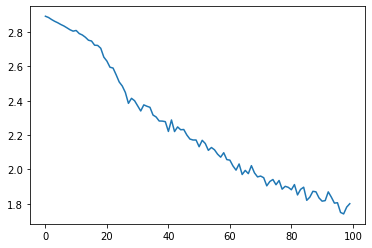

In [28]:
plt.figure()
plt.plot(all_losses)

In [29]:
# confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [30]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

/Users/hezhi/hohoho/tmp/pytoch_demo/utils.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/Users/hezhi/hohoho/tmp/pytoch_demo/utils.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


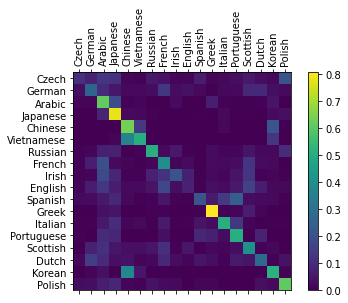

In [31]:
true_list = list()
predict_list = list()

for i in range(n_confusion):
    category, line, catetory_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output, all_categories)
    category_i = all_categories.index(category)
    true_list.append(category_i)
    predict_list.append(guess_i)
#     confusion[category_i][guess_i] += 1
    
# for i in range(n_categories):
#     confusion[i] = confusion[i] / confusion[i].sum()
    
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(confusion.numpy())
# fig.colorbar(cax)

# ax.set_xticklabels([''] + all_categories, rotation = 90)
# ax.set_yticklabels([''] + all_categories)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# plt.show()

trues = torch.tensor(true_list)
predicts = torch.tensor(predict_list)
confustion_mat = plot_confusion_matrix(n_categories, trues, predicts, all_categories)